In [1]:
# Import useful packages
# Importing Libraries

!pip install matplotlib==3.4
import os
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from pandas.api.types import CategoricalDtype

#from category_encoders import MEstimateEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import  KFold, cross_val_score
from xgboost import XGBRegressor

import warnings
from matplotlib import style
style.use("ggplot")
sns.set_palette("Set3")


warnings.filterwarnings('ignore')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
import pandas as pd

## **DATA PREPROCESSING**

Before we train our model we have to prepare our data - we have to fill the missing values, we have to make sure that our data is in numerical form etc.

**Loading Data**

First we will read the data in the datasets.


In [3]:
df = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df.shape


(1460, 81)

In [6]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

**Clean Data**

Deal with missing values and select useful categorical features in this dataset.



**Visualize data**

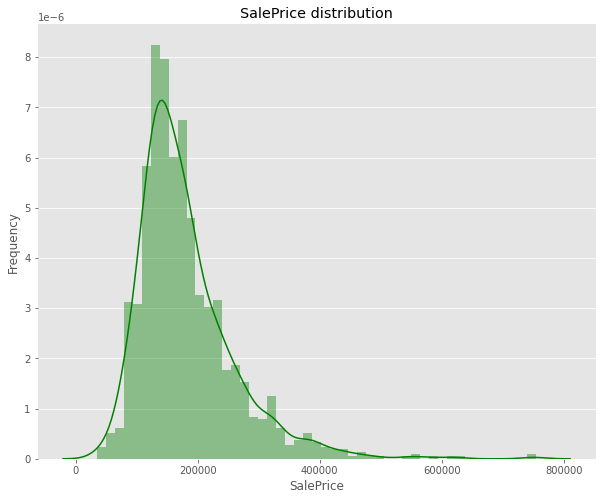

In [7]:

f, ax = plt.subplots(figsize=(10, 8))
sns.distplot(df['SalePrice'], color="g");
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

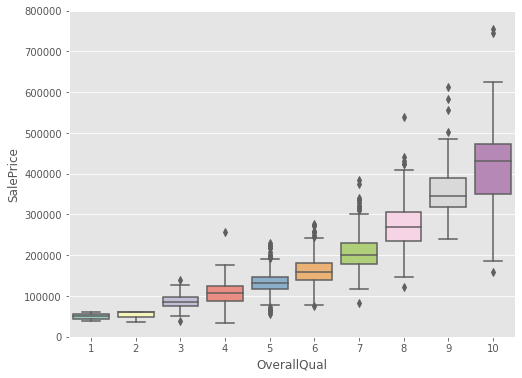

In [8]:
data = pd.concat([df['SalePrice'], df['OverallQual']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=df['OverallQual'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

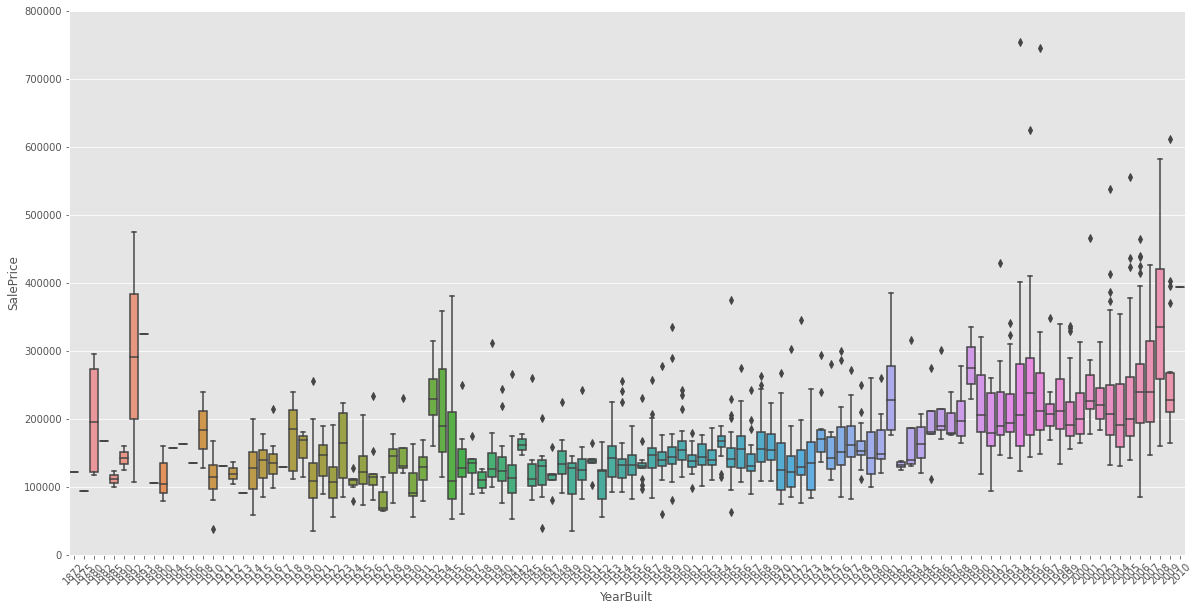

In [9]:
data = pd.concat([df['SalePrice'], df['YearBuilt']], axis=1)
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x=df['YearBuilt'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=45);

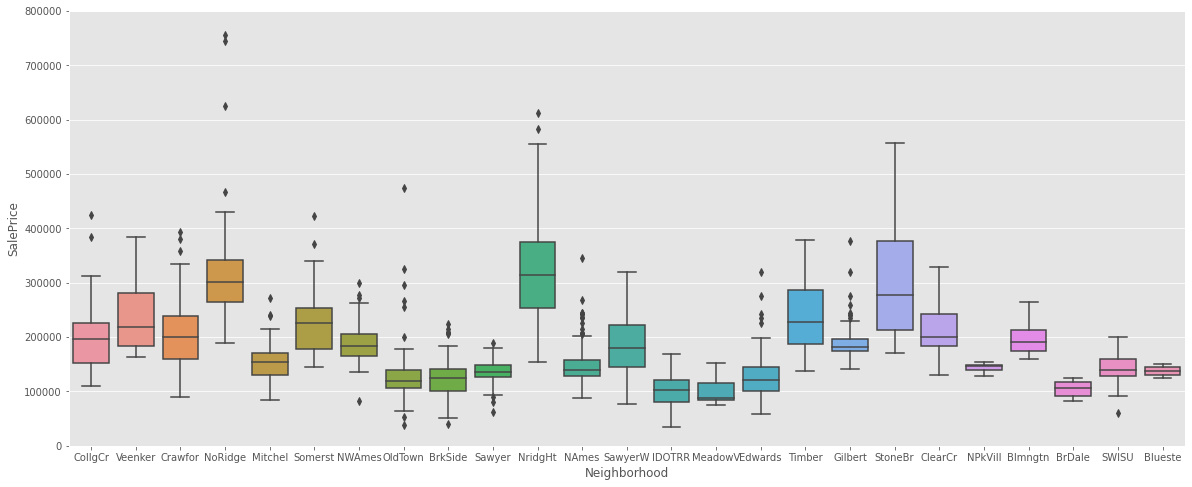

In [10]:
data = pd.concat([df['SalePrice'], df['Neighborhood']], axis=1)
f, ax = plt.subplots(figsize=(20, 8))
fig = sns.boxplot(x=df['Neighborhood'], y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

**Drop low correlation variables**

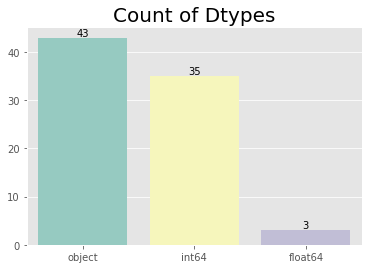

In [11]:
# Show varialbes in the data 


ax = sns.barplot(x = df.dtypes.value_counts().index, y = df.dtypes.value_counts()[[0,1,2]])
for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Count of Dtypes", fontsize = 20);

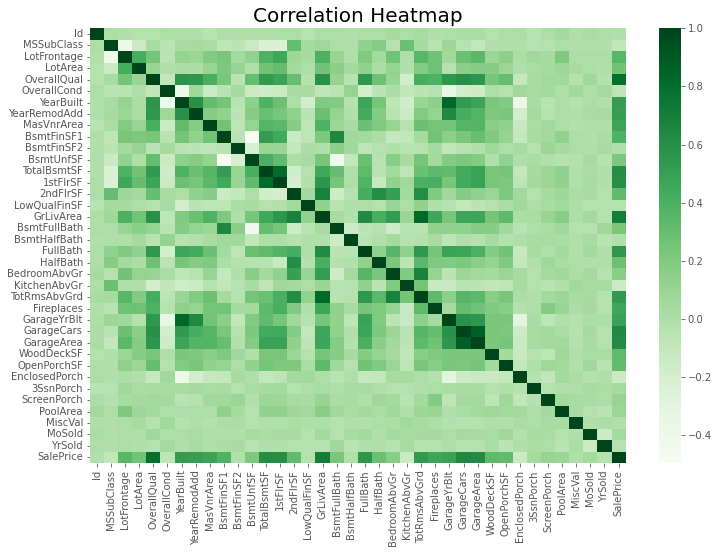

In [12]:
# There are 46 categorical and 34 numerical variables. We'll then check correlations of numeric variables.

plt.figure(figsize = (12,8))
sns.heatmap(df.corr(),cmap = "Greens")
plt.title("Correlation Heatmap", fontsize = 20);

In [13]:
cor = pd.DataFrame(df.corr()["SalePrice"].sort_values(ascending = False))
cor.columns = ["Correlation"]
cor[0:20]

,Correlation
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
GarageArea,0.623431
TotalBsmtSF,0.613581
1stFlrSF,0.605852
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897


In [14]:
# We will drop variables with <0.5 correlation and only get variables wiht >0.5 corralation

low_var = (cor.Correlation<0.5)[11:].index

df.drop(low_var, axis = 1, inplace = True)




In [ ]:
df.shape

**Check Null Values**

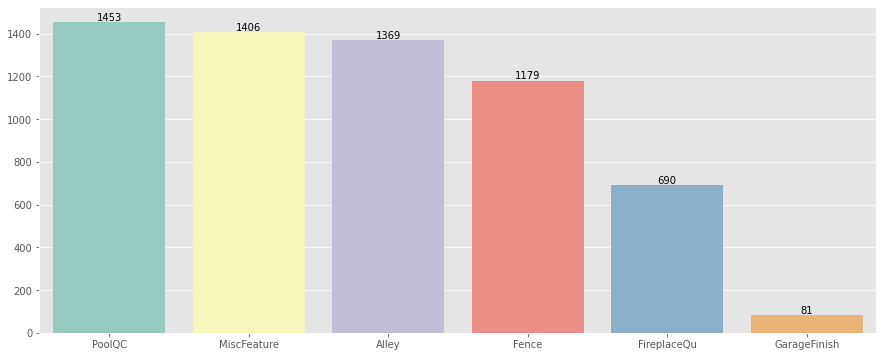

In [ ]:
plt.figure(figsize = (15,6))
ax = sns.barplot(x = df.isnull().sum().sort_values(
    ascending = False)[0:6].index, y = df.isnull().sum().sort_values(ascending = False)[0:6].values,)
for bars in ax.containers:
    ax.bar_label(bars)

PoolQC, MiscFeature, Alley, Fence and FireplaceQu have a lot of null values. So I will delete them directly.



In [ ]:
#creating a table that includes variables with having null values.
na_vars = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = False)
na_vars

#creating a dataframe that includes variables, nulls and their percentages.
nas = pd.DataFrame(na_vars)
nas["Percent"] = (na_vars.values / len(df) * 100)
nas.columns = ["Nulls", "Percent"]
nas

,Nulls,Percent
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
FireplaceQu,690,47.260274
GarageType,81,5.547945
GarageFinish,81,5.547945
GarageQual,81,5.547945
GarageCond,81,5.547945
BsmtExposure,38,2.602740


In [ ]:
df.drop(["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"], axis = 1, inplace = True)

# And we will choose only Quality features (GarageQual and BsmtQual) instead of involve all these features. 

df.drop(["GarageType", "GarageFinish", "GarageCond",
        "BsmtExposure", "BsmtFinType2", "BsmtCond", "BsmtFinType1"], axis = 1, inplace = True)

# Remove outliers
df.drop(df[(df['OverallQual']<5) & (df['SalePrice']>200000)].index, inplace=True)
#train.drop(train[(train['GrLivArea']>4500) & (train['SalePrice']<300000)].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [ ]:
na_vars = df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending = False)
nas = pd.DataFrame(na_vars)
nas["Percent"] = (na_vars.values / len(df) * 100)
nas.columns = ["Nulls", "Percent"]
nas

,Nulls,Percent
GarageQual,81,5.551748
BsmtQual,37,2.535984
MasVnrType,8,0.548321
Electrical,1,0.068540


Null variables for garages mean that house doesn't have garage. \\
Null variables for basements mean that house doesn't have basement. \\
We will fill 0 for null variables in these features.

For MasVnrType (Masonry veneer type), we will fill it with most frequent. \\
For Electrical, we will fill it with most frequent.

In [ ]:
df.GarageQual = df.GarageQual.fillna(0)
df.BsmtQual = df.BsmtQual.fillna(0)
df.MasVnrType = df.MasVnrType.fillna(df.MasVnrType.mode()[0])
df.Electrical = df.Electrical.fillna(df.Electrical.mode()[0])

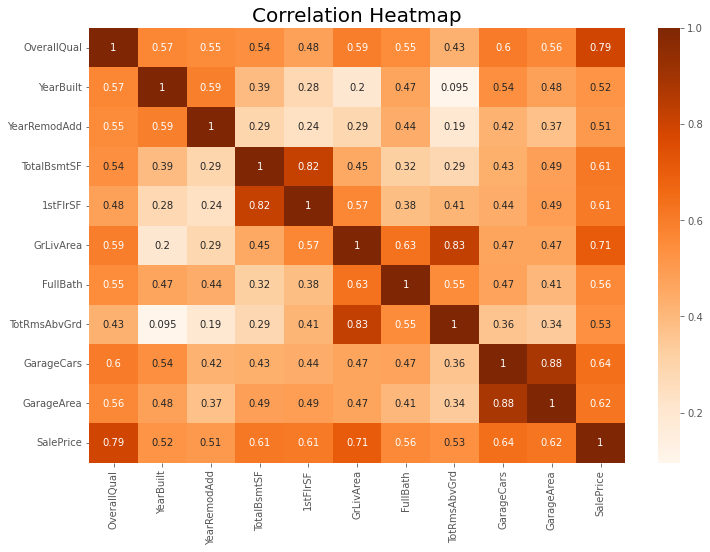

In [ ]:
plt.figure(figsize = (12,8))
sns.heatmap(df.corr(),cmap = "Oranges", annot = True)
plt.title("Correlation Heatmap", fontsize = 20);

TotalBsmtSF - 1stFlrSF \\
GrLivArea - TotRmsAbvGrd \\
GarageCars - GarageArea \\

**Checking VIF**

In [ ]:
#scaling the numeric data

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(df.select_dtypes(
    include = ["int64", "float64"]).drop("SalePrice", axis = 1))

X = pd.DataFrame(X, columns = list(df.select_dtypes(
    include = ["int64", "float64"]).drop("SalePrice", axis = 1)))
  
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
vif_data

,feature,VIF
0,OverallQual,2.758457
1,YearBuilt,2.345314
2,YearRemodAdd,1.754253
3,TotalBsmtSF,3.601468
4,1stFlrSF,3.683465
5,GrLivArea,5.026102
6,FullBath,2.216598
7,TotRmsAbvGrd,3.358360
8,GarageCars,5.254193
9,GarageArea,4.931730


*There* is no VIF value that is over 10. All of them are good.



**Checking Skewness and Kurtosis**

If skewness < 3 AND 2 > kurtosis > -2, it means normal distribution. We can make a logaritmic transformation to make it normal distribution.

In [ ]:
skewness_list = []
kurtosis_list = []
dfsk = pd.DataFrame(df.select_dtypes(include = ["int64", "float64"]).columns, columns = ["Variable"])

for var in df.select_dtypes(include = ["int64", "float64"]).columns:
    skewness_list.append(df[var].skew())
    kurtosis_list.append(df[var].kurtosis())
dfsk["Skewness"] = skewness_list
dfsk["Kurtosis"] = kurtosis_list
dfsk

,Variable,Skewness,Kurtosis
0,OverallQual,0.216663,0.099419
1,YearBuilt,-0.614506,-0.439266
2,YearRemodAdd,-0.502640,-1.273606
3,TotalBsmtSF,1.525704,13.253035
4,1stFlrSF,1.379837,5.762969
5,GrLivArea,1.366767,4.891627
6,FullBath,0.035218,-0.856276
7,TotRmsAbvGrd,0.675547,0.878046
8,GarageCars,-0.341845,0.218921
9,GarageArea,0.180459,0.914881


Looks like TotalBsmtSF, 1stFlrSF, GrLivArea and SalePrice aren't normal distribution. Let's check this.



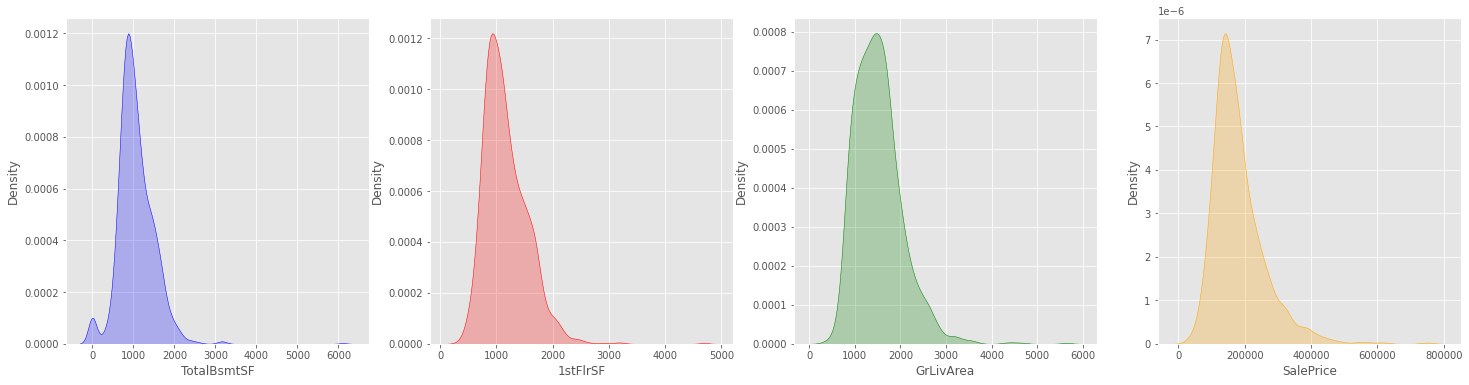

In [ ]:
plt.figure(figsize = (25,6))

plt.subplot(1,4,1)
sns.kdeplot(df.TotalBsmtSF, shade = True, color = "b")

plt.subplot(1,4,2)
sns.kdeplot(df["1stFlrSF"], shade = True, color = "r")

plt.subplot(1,4,3)
sns.kdeplot(df.GrLivArea, shade = True, color = "g")

plt.subplot(1,4,4)
sns.kdeplot(df.SalePrice, shade = True, color = "orange")
plt.show()


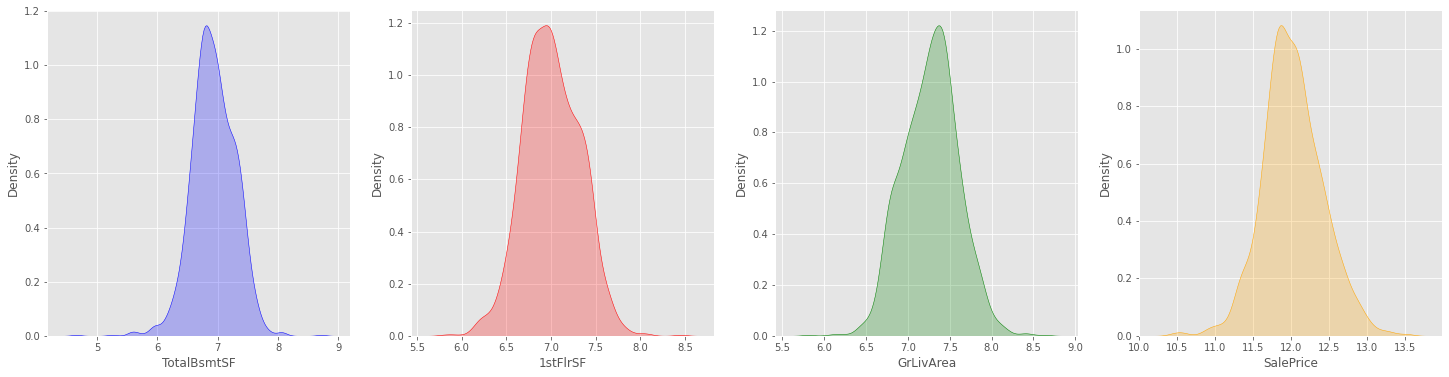

In [ ]:
df.TotalBsmtSF = np.log(df.TotalBsmtSF)
df["1stFlrSF"] = np.log(df["1stFlrSF"])
df.GrLivArea = np.log(df.GrLivArea)
df.SalePrice = np.log(df.SalePrice)

plt.figure(figsize = (25,6))

plt.subplot(1,4,1)
sns.kdeplot(df.TotalBsmtSF, shade = True, color = "b")

plt.subplot(1,4,2)
sns.kdeplot(df["1stFlrSF"], shade = True, color = "r")

plt.subplot(1,4,3)
sns.kdeplot(df.GrLivArea, shade = True, color = "g")

plt.subplot(1,4,4)
sns.kdeplot(df.SalePrice, shade = True, color = "orange")
plt.show()

**Checking Categorical Variables**

In [ ]:
dfo = df.select_dtypes(include = "object")
variables = dfo.columns

uniq_df = pd.DataFrame(variables, columns = ["Variable"])

unique_values = []
for var in variables:
    unique_values.append(dfo[var].unique())
    
uniq_df["Unique"] = unique_values
uniq_df

,Variable,Unique
0,MSZoning,"[RL, RM, C (all), FV, RH]"
1,Street,"[Pave, Grvl]"
2,LotShape,"[Reg, IR1, IR2, IR3]"
3,LandContour,"[Lvl, Bnk, Low, HLS]"
4,Utilities,"[AllPub, NoSeWa]"
5,LotConfig,"[Inside, FR2, Corner, CulDSac, FR3]"
6,LandSlope,"[Gtl, Mod, Sev]"
7,Neighborhood,"[CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ..."
8,Condition1,"[Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, ..."
9,Condition2,"[Norm, Artery, RRNn, Feedr, PosN, PosA, RRAn, ..."



ExterQual - ExterCond - BsmtQual - HeatingQC - KitchenQual - GarageQual are ORDINAL

CentralAir is Y/N so we will convert it to 1/0

Ex --> Excellent 5 \\
Gd --> Good 4 \\
TA --> Average/Typical 3 \\
Fa --> Fair 2 \\
Po --> Poor 1

In [ ]:
#We will convert them to ordinal numeric values
df[["ExterQual", "ExterCond", "BsmtQual", "HeatingQC", "KitchenQual", "GarageQual"]].head()

df.ExterQual = df.ExterQual.replace(["Gd", "TA", "Ex", "Fa"], [4, 3, 5, 2])
df.ExterCond = df.ExterCond.replace(["TA", "Gd", "Fa", "Po", "Ex"], [3, 4, 2, 1, 5])
df.BsmtQual = df.BsmtQual.replace(["Gd", "TA", "Ex", "Fa"], [4, 3, 5, 2])
df.HeatingQC = df.HeatingQC.replace(["Ex", "Gd", "TA", "Fa", "Po"], [5, 4, 3, 2, 1])
df.KitchenQual = df.KitchenQual.replace(["Gd", "TA", "Ex", "Fa"], [4, 3, 5, 2])
df.GarageQual = df.GarageQual.replace(["TA", "Fa", "Gd", "Ex", "Po"], [3, 2, 4, 5, 1])

df.ExterQual = df.ExterQual.astype("int64")
df.ExterCond = df.ExterCond.astype("int64")
df.BsmtQual = df.BsmtQual.astype("int64")
df.HeatingQC = df.HeatingQC.astype("int64")
df.KitchenQual = df.KitchenQual.astype("int64")
df.GarageQual = df.GarageQual.astype("int64")

df.CentralAir = df.CentralAir.replace(["Y", "N"], [1, 0])
df.CentralAir = df.CentralAir.astype("int64")

df[["ExterQual", "ExterCond", "BsmtQual", "HeatingQC", "KitchenQual", "GarageQual"]].head()


,ExterQual,ExterCond,BsmtQual,HeatingQC,KitchenQual,GarageQual
0,4,3,4,5,4,3
1,3,3,4,5,3,3
2,4,3,4,5,4,3
3,3,3,3,4,4,3
4,4,3,4,5,4,3


In [ ]:
df.dtypes.value_counts()


object     24
int64      14
float64     4
dtype: int64

In [ ]:
#creating last df with dummies
df_dum = pd.get_dummies(df, prefix = df.select_dtypes("object").columns)
df_dum.head()

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,7,2003,2003,4,3,4,6.752270,5,1,6.752270,...,0,0,0,1,0,0,0,0,1,0
1,6,1976,1976,3,3,4,7.140453,5,1,7.140453,...,0,0,0,1,0,0,0,0,1,0
2,7,2001,2002,4,3,4,6.824374,5,1,6.824374,...,0,0,0,1,0,0,0,0,1,0
3,7,1915,1970,3,3,3,6.628041,4,1,6.867974,...,0,0,0,1,1,0,0,0,0,0
4,8,2000,2000,4,3,4,7.043160,5,1,7.043160,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
#df_dum.isnull().sum().sort_values(ascending = False)[0:188]
#np.where(df_dum.values >= np.finfo(np.float32).max)

df_dum[np.isnan(df_dum)] = np.median(df_dum[~np.isnan(df_dum)])

np.isnan(df_dum).any()

df_dum = df_dum.replace(np.inf, 1)
df_dum = df_dum.replace(np.NINF, 1)


In [ ]:
df_dum.describe()


In [ ]:
# df_train = df
last_variables = df_dum.drop("SalePrice", axis = 1).columns


In [ ]:
#y_result = df['SalePrice']
y_result = df_dum['SalePrice'].reset_index(drop=True)

df_dum = df_dum.drop(['SalePrice'],axis = 1)



## **Train Model**

First we split our training data: df

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_dum, y_result, test_size=.3, random_state=42)


In [ ]:
X_train

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
135,7,1970,1970,3,3,3,7.173192,4,1,7.427739,...,0,0,0,1,0,0,0,0,1,0
1451,5,2005,2005,3,3,4,6.304449,4,1,6.977281,...,0,0,0,1,0,0,0,0,1,0
1046,5,1994,1995,3,3,4,6.897705,5,1,6.897705,...,0,0,0,1,0,0,0,0,1,0
691,7,1989,1990,4,3,4,7.098376,5,1,7.121252,...,0,0,0,1,0,0,0,0,1,0
435,7,1996,1996,4,3,4,6.683361,5,1,6.717805,...,1,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,6,1914,2006,3,3,3,6.527958,3,1,6.650279,...,0,0,0,1,0,0,0,0,1,0
1130,5,1991,1992,3,3,4,6.881411,3,1,6.881411,...,0,0,1,0,1,0,0,0,0,0
1294,5,1968,1968,3,3,3,6.958448,4,1,6.958448,...,0,0,0,1,0,0,0,0,1,0
860,5,1965,1965,3,3,3,6.946014,5,1,6.946014,...,0,0,0,1,0,0,0,0,1,0


In [ ]:
#y_train  = y_train.to_frame()

y_train.shape

(1021,)

**Setup cross validation and define error metrics**

In [ ]:
# Setup cross validation folds
kf = KFold(n_splits=12, random_state=42, shuffle=True)

# Define error metrics
#def rmsle(y, y_pred):
#    return np.sqrt(mean_squared_error(y_train, y_pred))

def cv_rmse(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=kf))
    return (rmse)

**Model Tuning**

In [ ]:
lgbm_params = {
    'colsample_bytree': [0.4, 0.5,0.6,0.9,1],
    'learning_rate': [0.01, 0.1, 0.5,1],
    'n_estimators': [100, 200, 500, 1000, 3000, 7000]}

lgbm = LGBMRegressor()

lgbm_cv = GridSearchCV(lgbm, lgbm_params, cv = 10, n_jobs = -1)

lgbm_cv.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0.5, 0.6, 0.9, 1],
                         'learning_rate': [0.01, 0.1, 0.5, 1],
                         'n_estimators': [100, 200, 500, 1000, 3000, 7000]})

In [ ]:
lgbm_cv.best_params_

{'colsample_bytree': 0.4, 'learning_rate': 0.01, 'n_estimators': 500}

In [ ]:
xgboost_params = {
    'colsample_bytree': [0.4, 0.5,0.7,0.9,1],
    'max_depth': range (2, 4, 5),
    'n_estimators': [50, 100, 500, 1000, 3000, 6000],
    'learning_rate': [0.01, 0.1, 0.5,1]
}

xgboost = XGBRegressor()

xgboost_cv = GridSearchCV(xgboost, xgboost_params, cv = 3, n_jobs = -1)

xgboost_cv.fit(X_train, y_train)

[06:53:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3, estimator=XGBRegressor(), n_jobs=-1,
             param_grid={'colsample_bytree': [0.4, 0.5, 0.7, 0.9, 1],
                         'learning_rate': [0.01, 0.1, 0.5, 1],
                         'max_depth': range(2, 4, 5),
                         'n_estimators': [50, 100, 500, 1000, 3000, 6000]})

In [ ]:
xgboost_cv.best_params_

{'colsample_bytree': 0.4,
 'learning_rate': 0.01,
 'max_depth': 2,
 'n_estimators': 3000}

In [ ]:
svm_params = {#'kernel' : ('poly', 'rbf', 'sigmoid'),
         'C' : [5,10,20],
         #'degree' : [3,8],
         'epsilon' : [0.005, 0.01, 0.05, 0.1],
         'gamma' : [0.0003, 0.005, 0.01]}

svr = SVR()

svr_cv = GridSearchCV(svr, svm_params,cv=3, n_jobs = -1)

svr_cv.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [5, 10, 20], 'epsilon': [0.005, 0.01, 0.05, 0.1],
                         'gamma': [0.0003, 0.005, 0.01]})

In [ ]:
svr_cv.best_params_

{'C': 20, 'epsilon': 0.05, 'gamma': 0.0003}

In [ ]:
rf_params = { 
    'n_estimators': [200, 500, 800, 1200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [5, 8, 12, 15],
  #  'criterion' :['gini', 'entropy']
}

rf = RandomForestRegressor()

rf_cv = GridSearchCV(estimator=rf, param_grid=rf_params, cv= 3)

rf_cv.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 8, 12, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 500, 800, 1200]})

In [ ]:
rf_cv.best_params_

{'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 500}

**Setup models**

In [ ]:
# Before tuning

# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor()

# XGBoost Regressor
xgboost = XGBRegressor()

# Support Vector Regressor
svr = SVR()

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor()  

# Random Forest Regressor
rf = RandomForestRegressor()

In [ ]:
#After tuning
# Light Gradient Boosting Regressor
lightgbm1 = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=500,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost1 = XGBRegressor(learning_rate=0.01,
                       n_estimators=3000,
                       max_depth=2,
                       #min_child_weight=0,
                       #gamma=0.6,
                       #subsample=0.7,
                       colsample_bytree=0.4,
                       #objective='reg:linear',
                       #nthread=-1,
                       #scale_pos_weight=1,
                       #seed=27,
                       #reg_alpha=0.00006,
                       random_state=42)

# Support Vector Regressor
svr1 = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.05, gamma=0.0003))

# Gradient Boosting Regressor
gbr1 = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf1 = RandomForestRegressor(n_estimators=500,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

In [ ]:
#scoure = cross_val_score(lightgbm, X_train, y_train, scoring="neg_mean_squared_error", cv=kf, error_score = "raise")
#scoure

array([-0.02213578, -0.02704823, -0.01795137, -0.01223624, -0.01134144,
       -0.02124572, -0.01978772, -0.0132945 , -0.0175739 , -0.02048072,
       -0.02911955, -0.01815467])

In [ ]:
#xgboost.fit(X_train, y_train)

#pred = xgboost.predict(X_test)

#from sklearn.metrics import r2_score
#r2_score(pred, y_test)

[21:01:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


0.7923606456837808

In [ ]:
#rf.fit(X_train, y_train)

#pred = rf.predict(X_test)

#from sklearn.metrics import r2_score
#r2_score(pred, y_test)

0.8094679690396497

In [ ]:
svr1.fit(X_train, y_train)

pred = svr1.predict(X_test)

#from sklearn.metrics import r2_score
r2_score(pred, y_test)

0.8546046622550869

**Train models**

Get cross validation scores for each model


**Before parameter tuning**

In [ ]:
# Before paremeter tuning
scores = {}

score = cv_rmse(lightgbm, X_train, y_train)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['lgb'] = (score.mean(), score.std())

score = cv_rmse(xgboost, X_train, y_train)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['xgb'] = (score.mean(), score.std())

score = cv_rmse(svr, X_train, y_train)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['svr'] = (score.mean(), score.std())

score = cv_rmse(rf, X_train, y_train)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['rf'] = (score.mean(), score.std())

score = cv_rmse(gbr, X_train, y_train)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores['gbr'] = (score.mean(), score.std())

lightgbm: 0.1504 (0.0172)
[23:55:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:55:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:55:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:55:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:55:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:55:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:55:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:55:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now

In [ ]:
# After paremeter tuning
scores1 = {}

score = cv_rmse(lightgbm1, X_train, y_train)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores1['lgb'] = (score.mean(), score.std())

score = cv_rmse(xgboost1, X_train, y_train)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores1['xgb'] = (score.mean(), score.std())

score = cv_rmse(svr1, X_train, y_train)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores1['svr'] = (score.mean(), score.std())

score = cv_rmse(rf1, X_train, y_train)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores1['rf'] = (score.mean(), score.std())

score = cv_rmse(gbr1, X_train, y_train)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores1['gbr'] = (score.mean(), score.std())

lightgbm: 0.1476 (0.0162)
[22:01:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:01:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:01:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:02:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now

**Identify the best performing model**

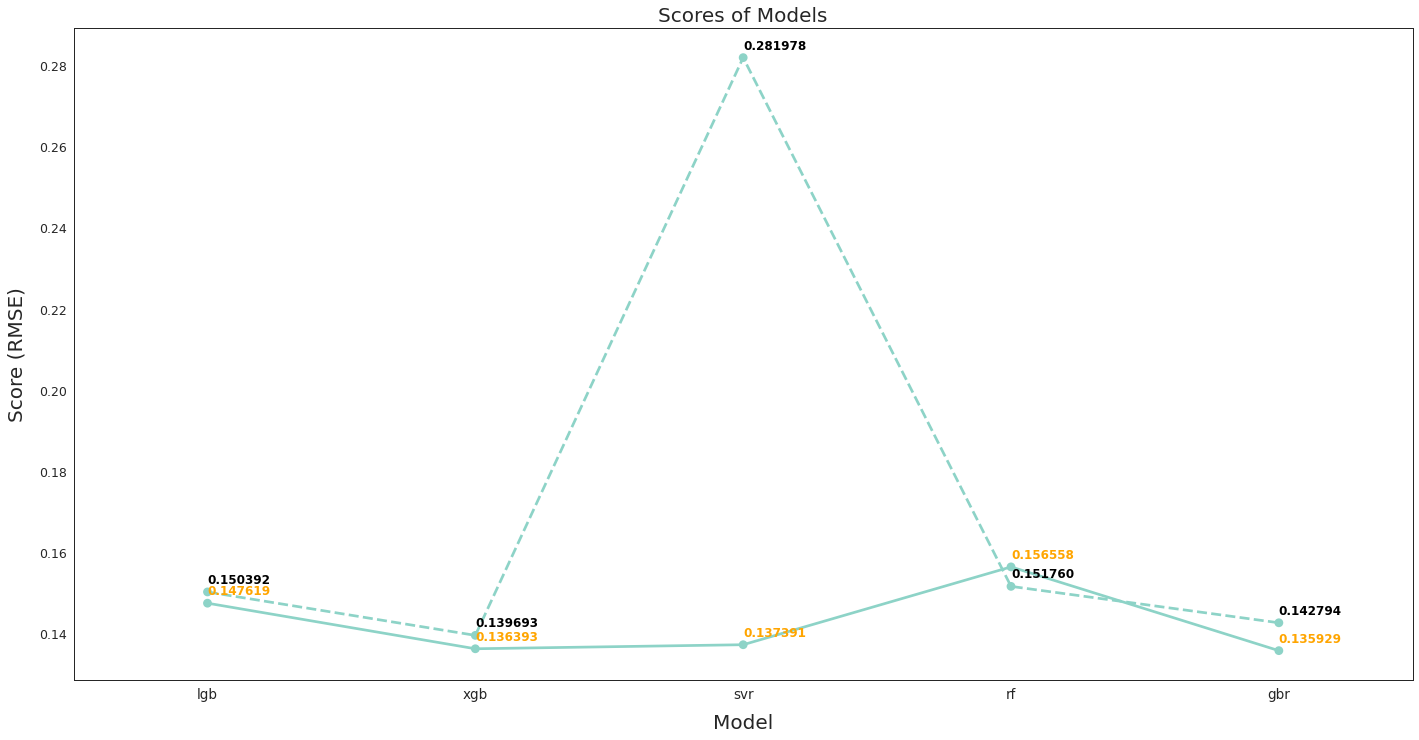

In [ ]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores.values()], markers=['o'], linestyles=['--'])
ax = sns.pointplot(x=list(scores.keys()), y=[score for score, _ in scores1.values()], markers=['o'], linestyles=['-'])

for i, score in enumerate(scores.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

for i, score in enumerate(scores1.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='orange', weight='semibold')


plt.ylabel('Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

Then we try K-means

In [ ]:
y_train

135     12.066811
1451    11.884489
1046    11.884489
691     12.721886
435     12.264342
          ...    
1095    11.751942
1130    11.445717
1294    11.838626
860     11.786762
1126    12.464583
Name: SalePrice, Length: 1021, dtype: float64

In [ ]:
#Cluster with important feature

#X2=pd.concat([df_dum,y_result],axis=1)

X2 = pd.concat([X_train,y_train],axis=1)
corre=X2.corr().iloc[:,-1]
corre=abs(corre)
corre=corre[corre>=0.5]
selectedfeature=corre.index.tolist()
print(selectedfeature)
selectedX2=X2[selectedfeature]
selectedX2
#Now, the selectedX2 contains values with abs(correlation)>=0.5, including saleprice

['OverallQual', 'YearBuilt', 'YearRemodAdd', 'ExterQual', 'BsmtQual', '1stFlrSF', 'GrLivArea', 'FullBath', 'KitchenQual', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea', 'Foundation_PConc', 'SalePrice']


,OverallQual,YearBuilt,YearRemodAdd,ExterQual,BsmtQual,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageCars,GarageArea,Foundation_PConc,SalePrice
135,7,1970,1970,3,3,7.427739,7.427739,2,3,7,2,530,1,12.066811
1451,5,2005,2005,3,4,6.977281,6.977281,1,3,5,2,525,1,11.884489
1046,5,1994,1995,3,4,6.897705,6.897705,1,3,5,2,672,1,11.884489
691,7,1989,1990,4,4,7.121252,7.831617,2,4,9,2,628,1,12.721886
435,7,1996,1996,4,4,6.717805,7.415175,2,4,6,2,550,1,12.264342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,6,1914,2006,3,3,6.650279,7.211557,1,4,7,0,0,1,11.751942
1130,5,1991,1992,3,4,6.881411,6.881411,1,3,5,0,0,1,11.445717
1294,5,1968,1968,3,3,6.958448,6.958448,1,3,5,1,288,0,11.838626
860,5,1965,1965,3,3,6.946014,6.946014,1,3,6,2,504,1,11.786762


In [ ]:
selectedX2.shape

(1021, 14)

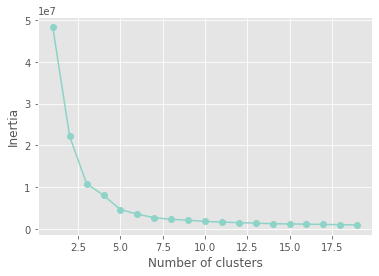

In [ ]:
selectedX2=selectedX2.to_numpy()
selectedX2=selectedX2.astype(float)
inertia=[]
for i in range(1,20):
    km=KMeans(
        n_clusters=i,init='k-means++',
        n_init=1, max_iter=100,
        tol=1e-04,random_state=0
    )
    km.fit(X2)
    inertia.append(km.inertia_)
plt.plot(range(1, 20), inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [ ]:
km=KMeans(
        n_clusters=5,init='k-means++',
        n_init=1, max_iter=100,
        tol=1e-04,random_state=0
    )
km.fit(selectedX2)
labels=km.labels_
label=pd.DataFrame(labels,columns=['label'])
X_new=pd.concat([X_train,y_train,label],axis=1)
X_new.sort_values(by=['label'])
cluster1=X_new.loc[X_new['label']==0]
cluster2=X_new.loc[X_new['label']==1]
cluster3=X_new.loc[X_new['label']==2]
cluster4=X_new.loc[X_new['label']==3]
cluster5=X_new.loc[X_new['label']==4]
cluster1.drop(columns='label')
cluster2.drop(columns='label')
cluster3.drop(columns='label')
cluster4.drop(columns='label')
cluster5.drop(columns='label')

,OverallQual,YearBuilt,YearRemodAdd,ExterQual,ExterCond,BsmtQual,TotalBsmtSF,HeatingQC,CentralAir,1stFlrSF,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice
8,7.0,1931.0,1950.0,3.0,3.0,3.0,6.858565,4.0,1.0,6.929517,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,11.774520
45,9.0,2005.0,2005.0,5.0,3.0,5.0,7.468513,5.0,1.0,7.468513,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.675764
48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,7.0,1997.0,1998.0,3.0,3.0,4.0,6.963190,5.0,1.0,6.963190,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.299108
73,5.0,1954.0,2003.0,3.0,3.0,3.0,6.990257,4.0,1.0,6.990257,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,11.883799
118,7.0,1990.0,1990.0,3.0,3.0,4.0,7.422374,4.0,1.0,7.437795,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.676076
133,8.0,2001.0,2002.0,4.0,3.0,5.0,7.144407,5.0,1.0,7.167038,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,12.301383
165,5.0,1940.0,1999.0,3.0,4.0,3.0,6.467699,4.0,1.0,6.694562,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,11.755872
196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Cluster 1 
cluster1 = cluster1.fillna(cluster1.mode().iloc[0])

y_result_c1 = cluster1['SalePrice']
X_c1=cluster1.drop(['SalePrice'],axis=1)


X_train_c1, X_test_c1, y_train_c1, y_test_c1 = train_test_split(X_c1, y_result_c1, test_size=.3, random_state=42)



In [ ]:
scores_c1 = {}

score = cv_rmse(lightgbm1, X_train_c1, y_train_c1)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c1['lgb'] = (score.mean(), score.std())

score = cv_rmse(xgboost1, X_train_c1, y_train_c1)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c1['xgb'] = (score.mean(), score.std())

score = cv_rmse(svr1, X_train_c1, y_train_c1)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c1['svr'] = (score.mean(), score.std())

score = cv_rmse(rf1, X_train_c1, y_train_c1)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c1['rf'] = (score.mean(), score.std())

score = cv_rmse(gbr1, X_train_c1, y_train_c1)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c1['gbr'] = (score.mean(), score.std())

lightgbm: 0.1762 (0.0408)
[00:03:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:03:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now

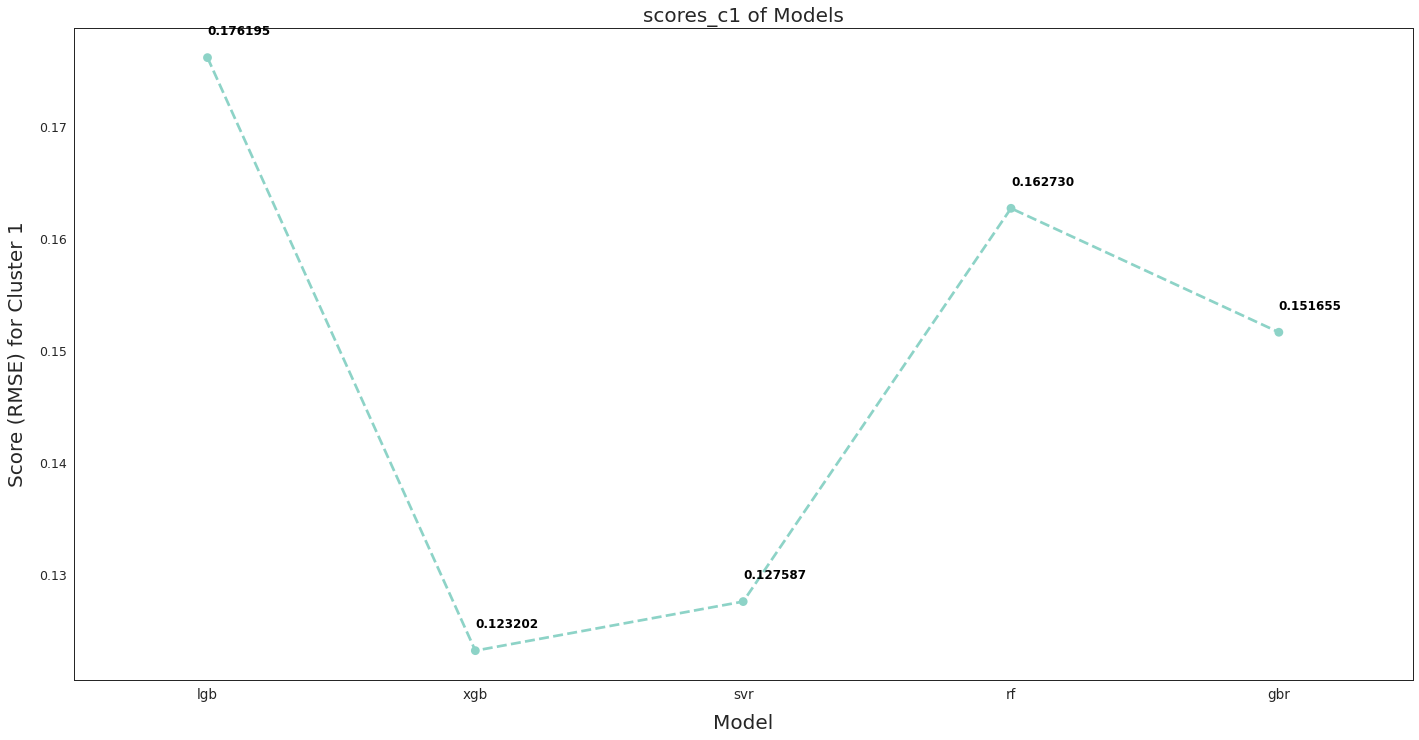

In [ ]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores_c1.keys()), y=[score for score, _ in scores_c1.values()], markers=['o'], linestyles=['--'])

for i, score in enumerate(scores_c1.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')



plt.ylabel('Score (RMSE) for Cluster 1', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores_c1 of Models', size=20)

plt.show()

In [ ]:
# Cluster 2
cluster2 = cluster2.fillna(cluster2.mode().iloc[0])

y_result_c2 = cluster2['SalePrice']
X_c2=cluster2.drop(['SalePrice'],axis=1)


X_train_c2, X_test_c2, y_train_c2, y_test_c2 = train_test_split(X_c2, y_result_c2, test_size=.3, random_state=42)

In [ ]:
scores_c2 = {}

score = cv_rmse(lightgbm1, X_train_c2, y_train_c2)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c2['lgb'] = (score.mean(), score.std())

score = cv_rmse(xgboost1, X_train_c2, y_train_c2)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c2['xgb'] = (score.mean(), score.std())

score = cv_rmse(svr1, X_train_c2, y_train_c2)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c2['svr'] = (score.mean(), score.std())

score = cv_rmse(rf1, X_train_c2, y_train_c2)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c2['rf'] = (score.mean(), score.std())

score = cv_rmse(gbr1, X_train_c2, y_train_c2)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c2['gbr'] = (score.mean(), score.std())

lightgbm: 0.2004 (0.0723)
[00:10:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:10:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:10:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:10:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:10:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:10:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:10:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:10:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now

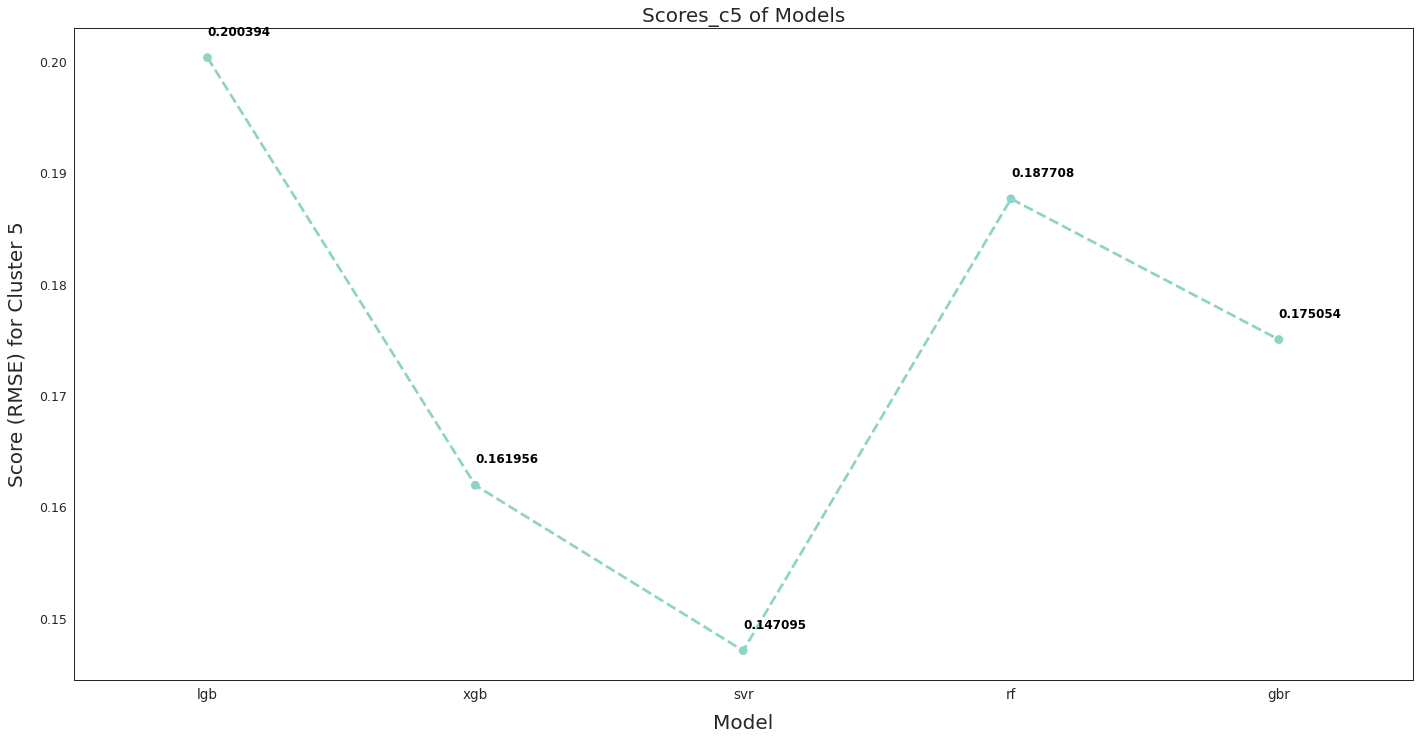

In [ ]:
# Plot the predictions for each model 2-5
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores_c2.keys()), y=[score for score, _ in scores_c2.values()], markers=['o'], linestyles=['--'])

for i, score in enumerate(scores_c2.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')



plt.ylabel('Score (RMSE) for Cluster 5', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores_c5 of Models', size=20)

plt.show()

In [ ]:
# Cluster 3
cluster3 = cluster3.fillna(cluster3.mode().iloc[0])

y_result_c3 = cluster3['SalePrice']
X_c3=cluster3.drop(['SalePrice'],axis=1)


X_train_c3, X_test_c3, y_train_c3, y_test_c3 = train_test_split(X_c3, y_result_c3, test_size=.3, random_state=42)

In [ ]:
scores_c3 = {}

score = cv_rmse(lightgbm1, X_train_c3, y_train_c3)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c3['lgb'] = (score.mean(), score.std())

score = cv_rmse(xgboost1, X_train_c3, y_train_c3)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c3['xgb'] = (score.mean(), score.std())

score = cv_rmse(svr1, X_train_c3, y_train_c3)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c3['svr'] = (score.mean(), score.std())

score = cv_rmse(rf1, X_train_c3, y_train_c3)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c3['rf'] = (score.mean(), score.std())

score = cv_rmse(gbr1, X_train_c3, y_train_c3)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c3['gbr'] = (score.mean(), score.std())

lightgbm: 0.1303 (0.0255)
[00:16:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:17:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:17:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:17:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:17:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:17:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:17:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:17:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now

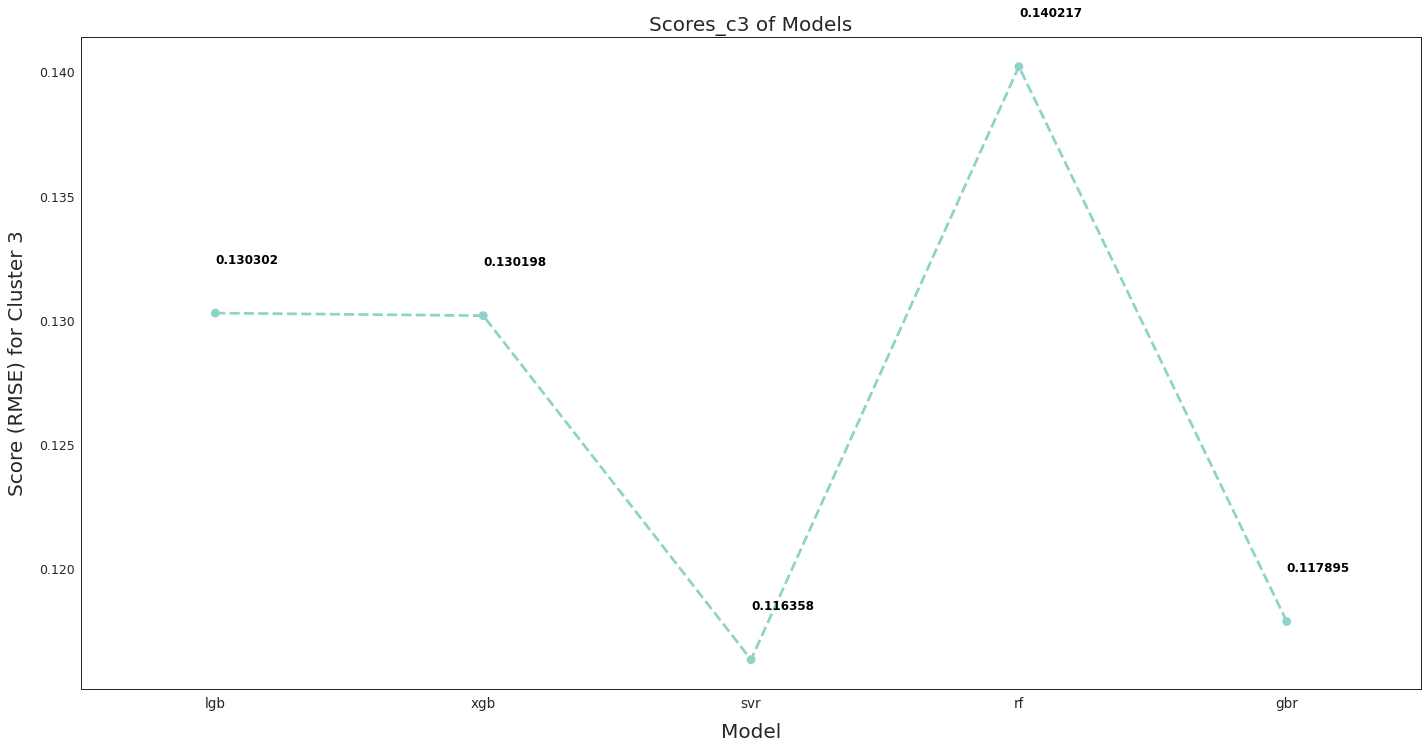

In [ ]:
# Plot the predictions for each model 
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores_c3.keys()), y=[score for score, _ in scores_c3.values()], markers=['o'], linestyles=['--'])

for i, score in enumerate(scores_c3.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')



plt.ylabel('Score (RMSE) for Cluster 3', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores_c3 of Models', size=20)

plt.show()

In [ ]:
# Cluster 4
cluster4 = cluster4.fillna(cluster4.mode().iloc[0])

y_result_c4 = cluster4['SalePrice']
X_c4=cluster4.drop(['SalePrice'],axis=1)


X_train_c4, X_test_c4, y_train_c4, y_test_c4 = train_test_split(X_c4, y_result_c4, test_size=.3, random_state=42)

In [ ]:
scores_c4 = {}

score = cv_rmse(lightgbm1, X_train_c4, y_train_c4)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c4['lgb'] = (score.mean(), score.std())

score = cv_rmse(xgboost1, X_train_c4, y_train_c4)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c4['xgb'] = (score.mean(), score.std())

score = cv_rmse(svr1, X_train_c4, y_train_c4)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c4['svr'] = (score.mean(), score.std())

score = cv_rmse(rf1, X_train_c4, y_train_c4)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c4['rf'] = (score.mean(), score.std())

score = cv_rmse(gbr1, X_train_c4, y_train_c4)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c4['gbr'] = (score.mean(), score.std())

lightgbm: 1.1071 (3.1898)
[00:23:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:23:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now

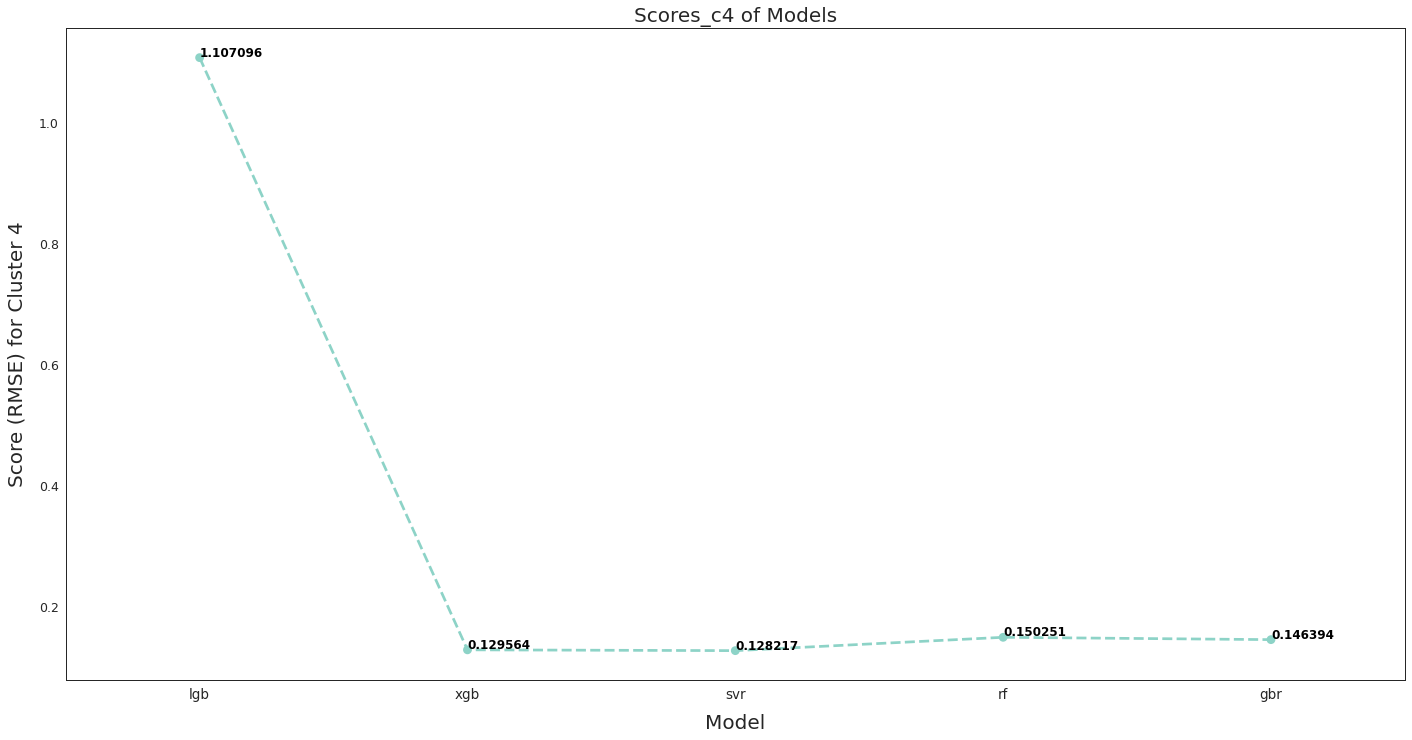

In [ ]:
# Plot the predictions for each model
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores_c4.keys()), y=[score for score, _ in scores_c4.values()], markers=['o'], linestyles=['--'])

for i, score in enumerate(scores_c4.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')



plt.ylabel('Score (RMSE) for Cluster 4', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores_c4 of Models', size=20)

plt.show()

In [ ]:
# Cluster 5

cluster5 = cluster5.fillna(cluster5.mode().iloc[0])

y_result_c5 = cluster5['SalePrice']
X_c5=cluster5.drop(['SalePrice'],axis=1)


X_train_c5, X_test_c5, y_train_c5, y_test_c5 = train_test_split(X_c5, y_result_c5, test_size=.3, random_state=42)

In [ ]:
scores_c5 = {}

score = cv_rmse(lightgbm1, X_train_c5, y_train_c5)
print("lightgbm: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c5['lgb'] = (score.mean(), score.std())

score = cv_rmse(xgboost1, X_train_c5, y_train_c5)
print("xgboost: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c5['xgb'] = (score.mean(), score.std())

score = cv_rmse(svr1, X_train_c5, y_train_c5)
print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c5['svr'] = (score.mean(), score.std())

score = cv_rmse(rf1, X_train_c5, y_train_c5)
print("rf: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c5['rf'] = (score.mean(), score.std())

score = cv_rmse(gbr1, X_train_c5, y_train_c5)
print("gbr: {:.4f} ({:.4f})".format(score.mean(), score.std()))
scores_c5['gbr'] = (score.mean(), score.std())

lightgbm: 0.3123 (0.2077)
[00:26:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:26:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now

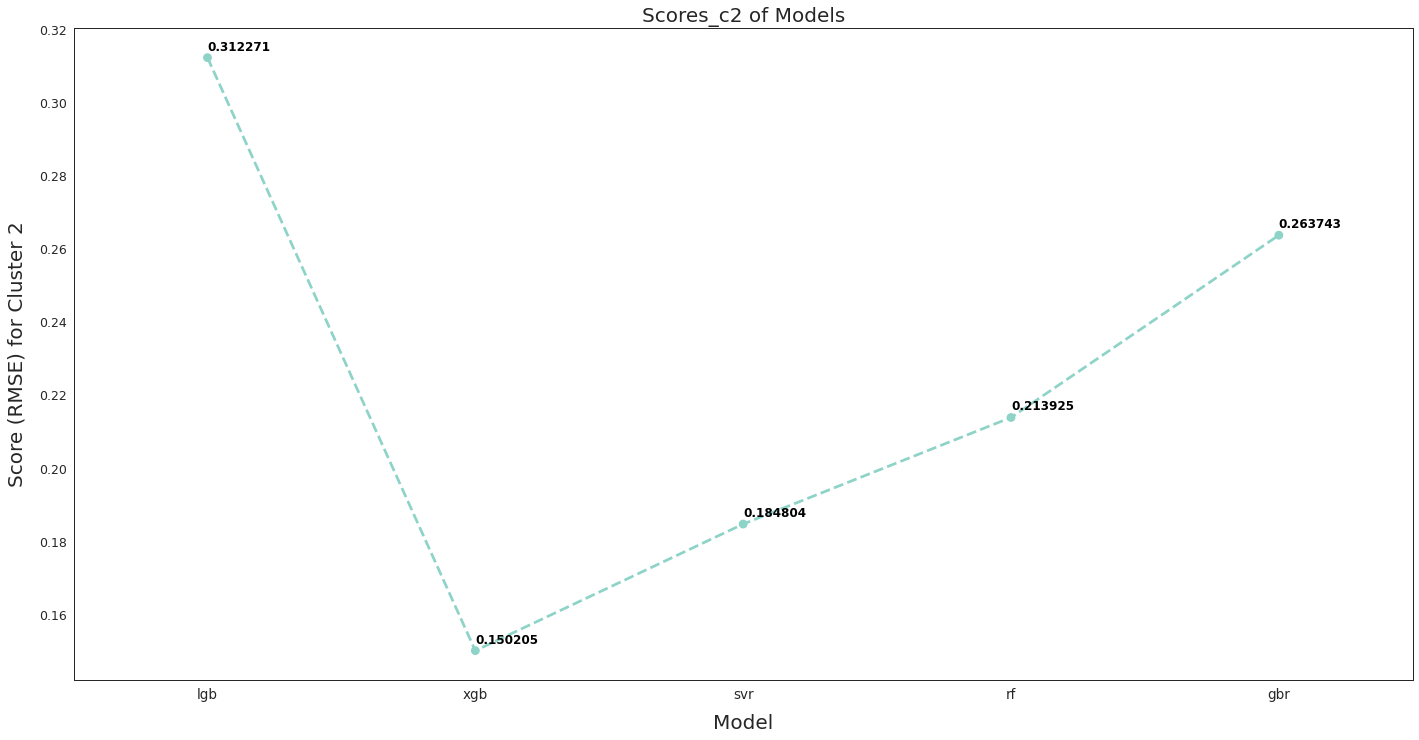

In [ ]:
# Plot the predictions for each model 5-2
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores_c5.keys()), y=[score for score, _ in scores_c5.values()], markers=['o'], linestyles=['--'])

for i, score in enumerate(scores_c5.values()):
    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')



plt.ylabel('Score (RMSE) for Cluster 2', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores_c2 of Models', size=20)

plt.show()

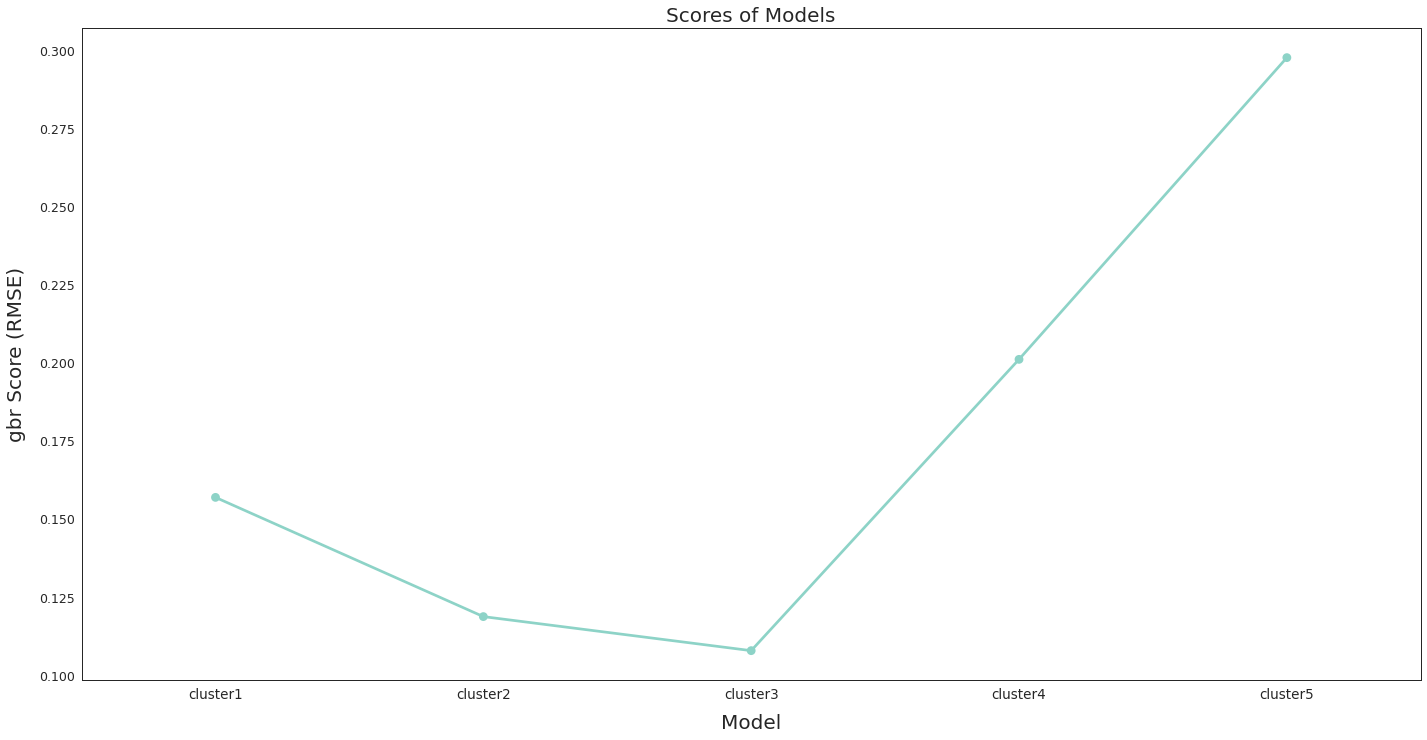

In [ ]:
#fit a model for all data and predict for each cluster

from sklearn.metrics import r2_score,mean_squared_error
scores5 = {}

cluster=[X_new,cluster1,cluster2,cluster3,cluster4,cluster5]
clustername=['cluster1','cluster2','cluster3','cluster4','cluster5']

scores_total = {}

traindata5 = [X_train_c1,X_train_c2,X_train_c3,X_train_c4,X_train_c5]
testdata5 = [y_train_c1,y_train_c2,y_train_c3,y_train_c4,y_train_c5]

traindata_t = [X_test_c1,X_test_c2,X_test_c3,X_test_c4,X_test_c5]
testdata_t = [y_test_c1,y_test_c2,y_test_c3,y_test_c4,y_test_c5]

#y_result2=cluster[0]['SalePrice']
#df_dum2=cluster[0].drop(['SalePrice'],axis=1)
#X_train, X_test, y_train, y_test = train_test_split(df_dum2, y_result2, test_size=.3, random_state=42)

#svr.fit(X_train,y_train)

#y_pred=svr.predict(X_test)

#rmse=np.sqrt(mean_squared_error(y_test,y_pred))

#scores[clustername[0]] = rmse

for i in range(0,len(cluster)-1):
    #y_result2=cluster[i]['SalePrice']
    #df_dum2=cluster[i].drop(['SalePrice'],axis=1)
    #X_train, X_test, y_train, y_test = train_test_split(df_dum2, y_result2, test_size=.3, random_state=42)

    gbr1.fit(traindata5[i], testdata5[i])
    y_pred=gbr1.predict(traindata_t[i])

    rmse=np.sqrt(mean_squared_error(y_pred,testdata_t[i]))
    
   ## score = cv_rmse(svr)##这里改一下，fit这个loop里的x_train y_train,应该算出一个error score
   ## print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
    scores5[clustername[i]] = rmse


    
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores5.keys()), y=list(scores5.values()), markers=['o'], linestyles=['-'])
#for i, score in enumerate(scores5.values()):
#    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('gbr Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()

[01:06:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[01:06:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


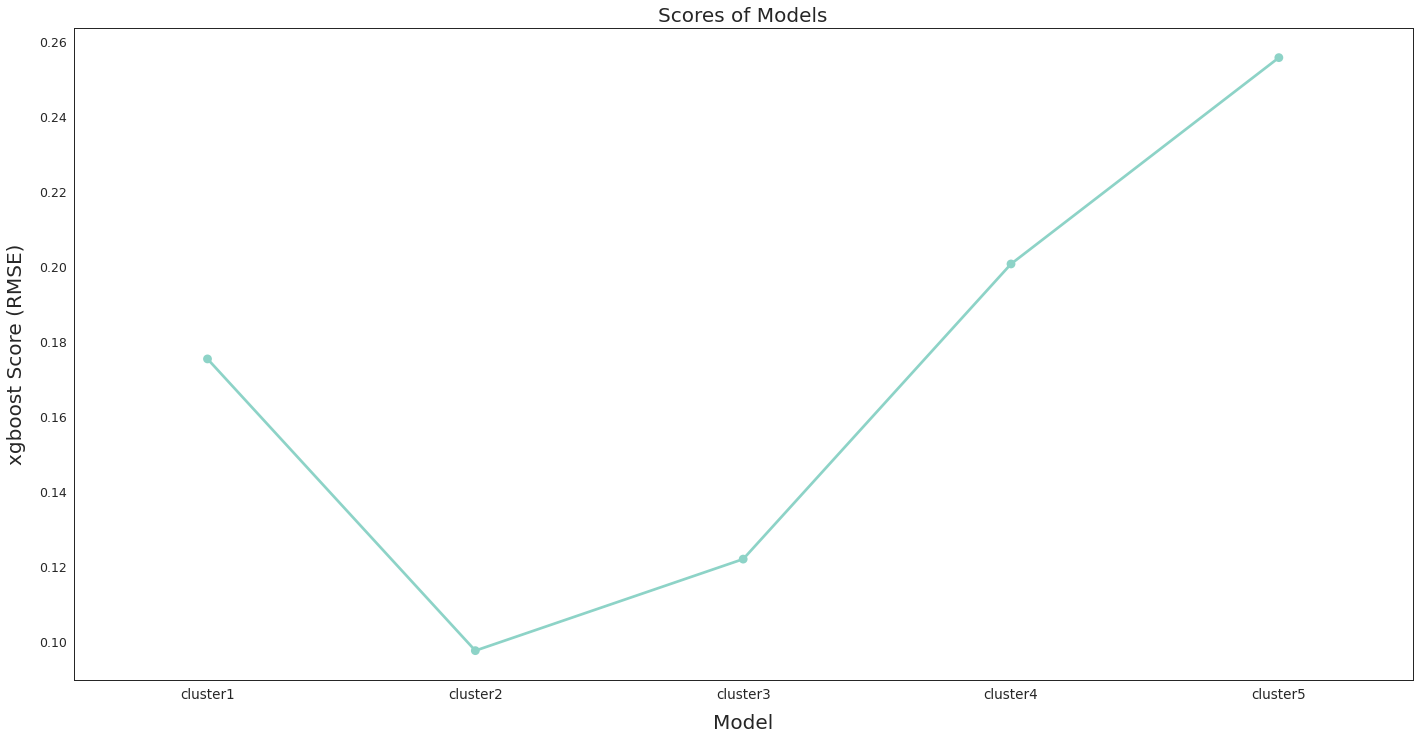

In [ ]:
scores5_new = {}

cluster=[X_new,cluster1,cluster2,cluster3,cluster4,cluster5]
clustername=['cluster1','cluster2','cluster3','cluster4','cluster5']

scores_total = {}



#y_result2=cluster[0]['SalePrice']
#df_dum2=cluster[0].drop(['SalePrice'],axis=1)
#X_train, X_test, y_train, y_test = train_test_split(df_dum2, y_result2, test_size=.3, random_state=42)

#svr.fit(X_train,y_train)

#y_pred=svr.predict(X_test)

#rmse=np.sqrt(mean_squared_error(y_test,y_pred))

#scores[clustername[0]] = rmse

for i in range(0,len(cluster)-1):
    #y_result2=cluster[i]['SalePrice']
    #df_dum2=cluster[i].drop(['SalePrice'],axis=1)
    #X_train, X_test, y_train, y_test = train_test_split(df_dum2, y_result2, test_size=.3, random_state=42)

    xgboost1.fit(traindata5[i], testdata5[i])
    y_pred=xgboost1.predict(traindata_t[i])

    rmse=np.sqrt(mean_squared_error(y_pred,testdata_t[i]))
    
   ## score = cv_rmse(svr)##这里改一下，fit这个loop里的x_train y_train,应该算出一个error score
   ## print("SVR: {:.4f} ({:.4f})".format(score.mean(), score.std()))
    scores5_new[clustername[i]] = rmse


    
sns.set_style("white")
fig = plt.figure(figsize=(24, 12))

ax = sns.pointplot(x=list(scores5_new.keys()), y=list(scores5_new.values()), markers=['o'], linestyles=['-'])
#for i, score in enumerate(scores5.values()):
#    ax.text(i, score[0] + 0.002, '{:.6f}'.format(score[0]), horizontalalignment='left', size='large', color='black', weight='semibold')

plt.ylabel('xgboost Score (RMSE)', size=20, labelpad=12.5)
plt.xlabel('Model', size=20, labelpad=12.5)
plt.tick_params(axis='x', labelsize=13.5)
plt.tick_params(axis='y', labelsize=12.5)

plt.title('Scores of Models', size=20)

plt.show()